In [ ]:
# Use svg graphics, display inline
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

import glob
import re
import copy
import sys
import re

# Basic scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hex colors for plotting
FB_BLUE = '#1877F2'
FB_HERITAGE_BLUE = '#3B5998'
FB_LIGHT_BLUE = '#8B9DC3'
FB_VERY_LIGHT_BLUE = '#dfE3EE'
SOFT_RED = '#C23F38'
SOFT_GREEN = '#56B000'
NEUTRAL_GREY = '#A9A9A9'
GGPLOT_PALETTE = [
	'#F8766F', '#E58700', '#C99800', '#A3A500', '#6BB100',
	'#00BA38', '#00BF7D', '#00C0AF', '#00BCD8', '#00B0F6',
	'#619CFF', '#B983FF', '#E76BF3', '#FD61D1', '#FF67A4'
]

# display config
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows = 999
plt.style.use('default')
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams["figure.dpi"] = 300
np.set_printoptions(suppress=True)
np.random.seed(42)

from wikipedia import wikipedia
from nltk import tokenize
import requests
from bs4 import BeautifulSoup
import json

pd.set_option('max_colwidth', 300)


#import spacy library
import spacy
#load core english library
nlp = spacy.load("en_core_web_sm")


print(sys.version)

In [427]:
url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/top/en.wikipedia/all-access/2021/09/all-days'
headers = {
    'User-agent': '(Kyle Johnson; kylejohnson.ai)'
}

results = eval(requests.get(url, headers=headers).content)
data = results['items'][0]['articles'][:500]

df = pd.DataFrame(data)
df.head(5)

,article,views,rank
0,Main_Page,178874181,1
1,Special:Search,45366099,2
2,Squid_Game,5929582,3
3,Emma_Raducanu,5601373,4
4,Shang-Chi_and_the_Legend_of_the_Ten_Rings,4778203,5


In [87]:
rows = []
for i, article in enumerate(df.article.values):
    
    article_name = article.replace('_', ' ')

    try:
        page = wikipedia.WikipediaPage(article_name)
    except:
        print(f'{article_name} caused an issue')
        rows.append((None,) * 5)
        continue
    
    categories = []
    try:
        categories = page.categories
    except:
        print(f'couldn\'t get the categories for {page.title}')

    row = (
        page.pageid,
        categories,
        page.title,
        page.content,
        len(page.content),
    )

    rows.append(row)
    
    if i % 100 == 0: 
        print(f'finished {i}/{df.shape[0]}')

couldn't get the categories for Main Page
finished 0/500
Special:Search caused an issue


/opt/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/anaconda3/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


XXXX caused an issue
Cinderella (2021 film) caused an issue
File:HispanTv logo.svg caused an issue
finished 100/500
finished 200/500
BF caused an issue
Special:Watchlist caused an issue
finished 300/500
Special:RecentChanges caused an issue
Null caused an issue
finished 400/500
File:Bally sports logo.svg caused an issue


Limit results to the top 500 articles

In [45]:
rows = rows[:500]

Merge the new data. Indicate which articles might actually be non-articles

In [246]:
df['page_id'] = [row[0] for row in rows]
df['category'] = [row[1] for row in rows]
df['title'] = [row[2] for row in rows]
df['content'] = [row[3] for row in rows]
df['length'] = [row[4] for row in rows]

not_valid_names = ['Wikipedia:About', 'Help:IPA/English']
df['is_valid_page'] = [1 if content and name not in not_valid_names else 0 for content, name in df[['content', 'article']].values]
df['word_count'] = [len(x.split(' ')) if x else 0 for x in df.content]

In [247]:
df.head(5)

,article,views,rank,page_id,category,title,content,length,valid_page,word_count,is_valid_page
0,Main_Page,178874181,1,15580374,[],Main Page,,0.000,0,0,0
1,Special:Search,45366099,2,None,None,None,None,NaN,0,0,0
2,Squid_Game,5929582,3,68455171,"[2020s fads and trends, 2021 South Korean tele...",Squid Game,Squid Game (Korean: 오징어 게임; RR: Ojing-eo Geim)...,34065.000,1,5608,1
3,Emma_Raducanu,5601373,4,67867692,"[2002 births, Articles containing Romanian-lan...",Emma Raducanu,Emma Raducanu (; born 13 November 2002) is a B...,10718.000,1,1775,1
4,Shang-Chi_and_the_Legend_of_the_Ten_Rings,4778203,5,59233722,"[2020s English-language films, 2020s fantasy a...",Shang-Chi and the Legend of the Ten Rings,Shang-Chi and the Legend of the Ten Rings is a...,50238.000,1,8255,1


Pickle the intermediate dataframe

In [248]:
df.to_pickle('df_top_500.pkl')

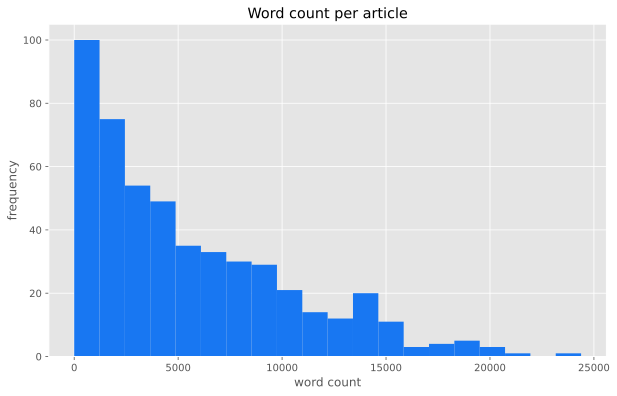

In [249]:
with plt.style.context('ggplot'):
    plt.hist(df.word_count, bins=20, color=FB_BLUE)
    plt.xlabel('word count')
    plt.ylabel('frequency')
    plt.title('Word count per article')

Super interesting word count distribution

## Splitting into paragraphs

In [453]:
df[df.is_valid_page == True].sample(5)

AttributeError: 'DataFrame' object has no attribute 'is_valid_page'

Create functions to break an article up into paragraphs and sentences

In [309]:
def get_paragraphs_from_article(article):
    try:
        paragraphs = article.split('\n')
    except:
        print(article)
        return []
    
    delimiters = ['== Notes ==', '== Bibliography ==', '== See also ==', '== References ==', '== External links ==']
    for delimiter in delimiters:
        paragraphs = [x.split(delimiter)[0] for x in paragraphs]
    
    paragraphs = [x for x in paragraphs if x and not x.startswith('==') and 'Retrieved' not in x]
    return paragraphs

def get_sentences_from_paragraph(paragraph):
    return tokenize.sent_tokenize(paragraph)

Plot the distribution of sentences per paragraph. We don't want one paragraph to take up more than 8 or 9 segments, given that we'll only be able to label 500 of them.

In [297]:
sentence_counts = []
for a in df[df.is_valid_page == True].content:
    for p in get_paragraphs_from_article(a):
        sentence_count = len(get_sentences_from_paragraph(p))
        sentence_counts.append(sentence_count)

sentence_counts = np.array(sentence_counts)

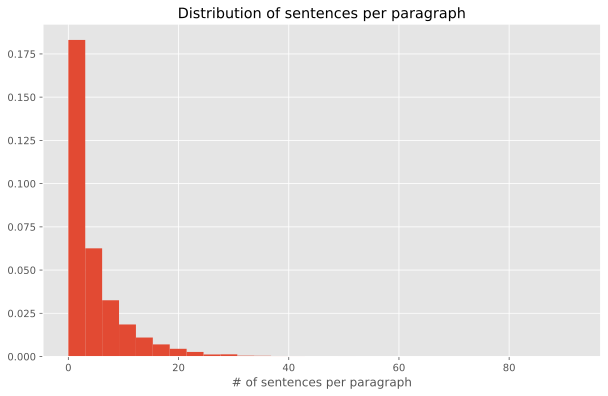

In [298]:
with plt.style.context('ggplot'):
    plt.hist(sentence_counts, bins=30, density=True)
    plt.xlabel('# of sentences per paragraph')
    plt.title('Distribution of sentences per paragraph')
    plt.show()

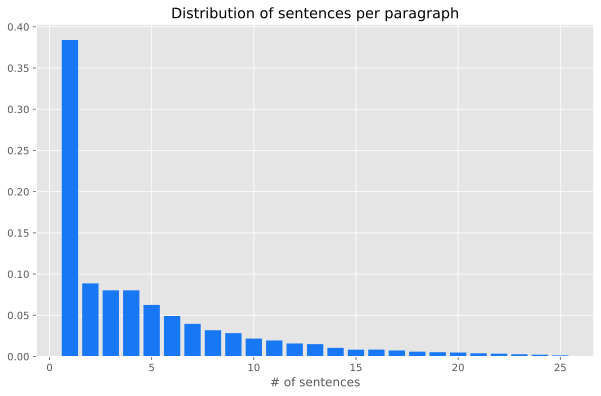

In [299]:
percs = pd.value_counts(sentence_counts) / pd.value_counts(sentence_counts).sum()
percs = percs.items()
df_percs = pd.DataFrame(percs, columns=['n_sentences', 'perc']).sort_values('n_sentences').reset_index().drop('index', axis=1)
df_percs = df_percs[df_percs.n_sentences > 0]

with plt.style.context('ggplot'):
    data = df_percs[:25]
    plt.bar(data.n_sentences, data.perc, color=FB_BLUE)
    plt.xlabel('# of sentences')
    plt.title('Distribution of sentences per paragraph')
    plt.show()

What percentage of paragraphs are between 3 and 8 sentences?

In [300]:
np.mean((3 <= sentence_counts) & (sentence_counts <= 8))

0.34359545004945596

Create a function to sample a valid paragraph from an article

In [301]:
def get_sample_paragraph(article, min_sentences=3, max_sentences=8):
    paragraphs = get_paragraphs_from_article(article)
    paragraphs = [p for p in paragraphs if min_sentences <= len(get_sentences_from_paragraph(p)) <= max_sentences]
    
    try:
        sample = np.random.choice(paragraphs)
    except:
        return None
    return sample
    
get_sample_paragraph(df.content[3])

"Raducanu won the ITF Chandigarh Lawn Tennis girls tournament at the beginning of 2018. In 2018 she won ITF grade-3 at Chandigarh and grade-2 junior tournament at New Delhi both in India. Raducanu defeated Diana Khodan of Ukraine in the final at Chandigarh, held at Chandigarh Lawn Tennis Association Stadium, where she won in straight sets.Later that year, she reached the girls' singles quarterfinals at both the Wimbledon Championships and the US Open. At Wimbledon, Raducanu defeated Leylah Fernandez in the second round, a feat she would eventually repeat in the senior US Open final three years later."

Create a dataframe with one sampled paragraph from each article

In [321]:
df_samples = df[df.is_valid_page == True][['page_id', 'title', 'content']].sample(100)

df_samples['sample_paragraph'] = [get_sample_paragraph(article, max_sentences=9) for article in df_samples.content]
df_samples.dropna(axis=0, subset=['sample_paragraph'], inplace=True)

df_samples['sample_sentence_count'] = [len(get_sentences_from_paragraph(x)) if x else None for x in df_samples.sample_paragraph]
df_samples['sample_char_count'] = [len(x) if x else None for x in df_samples.sample_paragraph]
df_samples['avg_sentence_length'] = df_samples.sample_char_count / df_samples.sample_sentence_count
df_samples.dropna(axis=0, subset=['sample_paragraph'], inplace=True)
df_samples = df_samples[df_samples.avg_sentence_length > 50]


df_samples.sample_sentence_count.sum()

489

In [322]:
out_columns = [
    'page_id', 
    'title', 
    'sample_paragraph', 
    'sample_sentence_count', 
    'sample_char_count', 
    'avg_sentence_length'
]
# df_samples[out_columns].to_csv('df_samples.tsv', sep='\t', index=False)

## Generate a dataframe with the actual segments
----

Note: I did some manual cleaning here to fix a few things. For example, it seems as though the API replaced footnote superscripts with `''` instead of `' '`. The result is sentences that don't have a space before them.

In [457]:
df_samples.head()

,page_id,title,content,sample_paragraph,sample_sentence_count,sample_char_count,avg_sentence_length
48,5043734,Wikipedia,"Wikipedia ( (listen) wik-ih-PEE-dee-ə or (listen) wik-ee-) is a free content, multilingual online encyclopedia written and maintained by a community of volunteers through a model of open collaboration, using a wiki-based editing system. Individual contributors, also called editors, are known as...","Semantic Web: The website DBpedia, begun in 2007, extracts data from the infoboxes and category declarations of the English-language Wikipedia. Wikimedia has created the Wikidata project with a similar objective of storing the basic facts from each page of Wikipedia and the other WMF wikis and m...",5,706,141.200
139,21951847,Hannah Waddingham,"Hannah Waddingham (born 28 July 1974) is an English actress and singer, known for her contribution to West End musical theatre, particularly her performances in the original London production of Spamalot, the 2010 Regent's Park revival of Into the Woods, and The Wizard of Oz (as the Wicked Witch...","Billed simply as Hannah, Waddingham placed ""Our Kind of Love"" in the UK Singles Chart in October 2000, where it peaked at No. 41.She later sang the role of Starbird on the soundtrack recording of Space Family Robinson, released by Pop! Records in May 2002 to coincide with the stage production (a...",3,402,134.000
481,62387071,Don't Look Up (2021 film),"Don't Look Up is an upcoming American science fiction black comedy film written, produced, and directed by Adam McKay and starring Leonardo DiCaprio and Jennifer Lawrence as two low-level astronomers attempting, via a media tour, to warn mankind about an approaching comet that will destroy Earth...","On February 19, 2020, it was announced that principal photography would start in April 2020. However, it was delayed due to the COVID-19 pandemic. Filming commenced on November 18, 2020, at various locations in Boston, Massachusetts. Part of the film takes place in New York City with Boston stan...",7,592,84.571
172,32005912,Grimes (musician),"Claire Elise Boucher (; born March 17, 1988), known professionally as Grimes, is a Canadian musician, singer, songwriter, and record producer. Her music has incorporated elements of varied styles, including dream pop, electronic, R&B, and hip hop, while touching on science fiction and feminist ...","The album's second single, ""Oblivion"", also received critical acclaim and was produced into a music video co-directed by Emily Kai Bock and Grimes. Pitchfork ranked ""Oblivion"" at number one on their 200 Best Tracks of the Decade So Far list in 2014. In interviews following the album's release, ...",5,1375,275.000
395,1256990,Candyman (1992 film),"Candyman is a 1992 American gothic supernatural horror film, written and directed by Bernard Rose and starring Virginia Madsen, Tony Todd, Xander Berkeley, Kasi Lemmons and Vanessa E. Williams. Based on Clive Barker's short story ""The Forbidden"", the film follows a Chicago graduate student compl...","When Helen returns to Cabrini-Green, a man calling himself the Candyman attacks her. She identifies her attacker, who turns out to be the head of a gang called the Overlords. The police assume he is responsible for the murders. The real Candyman appears to Helen in a parking garage and hypnotize...",7,643,91.857


In [327]:
df_samples.iloc[0].sample_paragraph

'Semantic Web: The website DBpedia, begun in 2007, extracts data from the infoboxes and category declarations of the English-language Wikipedia. Wikimedia has created the Wikidata project with a similar objective of storing the basic facts from each page of Wikipedia and the other WMF wikis and make it available in a queriable semantic format, RDF. As of April 2021, it has 93,337,731 items.Obtaining the full contents of Wikipedia for reuse presents challenges, since direct cloning via a web crawler is discouraged. Wikipedia publishes "dumps" of its contents, but these are text-only; as of 2007 there was no dump available of Wikipedia\'s images.  Wikimedia Enterprise is a for-profit solution to this.'

In [329]:
df_samples.sample_sentence_count.sum()

489

In [348]:
def missing_space_count(text):
    missing_count = 0
    for i in range(len(text) - 1):
        if text[i] == '.' and text[i+1] not in (' ', '"', '.'):
            missing_count += 1
    return missing_count

In [350]:
# for i, (title, pg) in enumerate(df_samples[['title', 'sample_paragraph']].values):
#     total_missing = missing_space_count(pg)
#     if total_missing:
#         print(i, title, total_missing)

## Read in the cleaned file
*cleaning was done in excel

In [353]:
df_cleaned = pd.read_excel('./paragraphs_cleaned.xlsx')
for column in 'page_id sample_sentence_count sample_char_count'.split(' '):
    df_cleaned[column] = df_cleaned[column].astype(int)
    
df_cleaned.head()

,page_id,title,sample_paragraph,sample_sentence_count,sample_char_count,avg_sentence_length
0,5043734,Wikipedia,"Semantic Web: The website DBpedia, begun in 20...",5,706,141.200
1,21951847,Hannah Waddingham,"Billed simply as Hannah, Waddingham placed ""Ou...",3,402,134.000
2,62387071,Don't Look Up (2021 film),"On February 19, 2020, it was announced that pr...",7,592,84.571
3,32005912,Grimes (musician),"The album's second single, ""Oblivion"", also re...",5,1375,275.000
4,1256990,Candyman (1992 film),"When Helen returns to Cabrini-Green, a man cal...",7,643,91.857


In [358]:
doc = df_cleaned.sample_paragraph[5]
doc

'After the planes struck the buildings, but before the buildings collapsed, the cores of both towers consisted of three distinct sections. Above and below the impact floors, the cores consisted of what were essentially two rigid boxes; the steel in these sections was undamaged and had undergone no significant heating. The section between them, however, had sustained significant damage and, though they were not hot enough to melt it, the fires were weakening the structural steel.'

In [378]:
sent_lists = [list(nlp(doc).sents) for doc in df_cleaned.sample_paragraph]
id_sents = [(id, sents) for id, sents in zip(df_cleaned.page_id, sent_lists)]
id_sents[:2]
# all_sents = '\n'.join(sent_lists)

[(5043734,
  [Semantic Web: The website DBpedia, begun in 2007, extracts data from the infoboxes and category declarations of the English-language Wikipedia.,
   Wikimedia has created the Wikidata project with a similar objective of storing the basic facts from each page of Wikipedia and the other WMF wikis and make it available in a queriable semantic format, RDF.,
   As of April 2021, it has 93,337,731 items.,
   Obtaining the full contents of Wikipedia for reuse presents challenges, since direct cloning via a web crawler is discouraged.,
   Wikipedia publishes "dumps" of its contents, but these are text-only; as of 2007 there was no dump available of Wikipedia's images.,
   Wikimedia Enterprise is a for-profit solution to this.]),
 (21951847,
  [Billed simply as Hannah, Waddingham placed "Our Kind of Love" in the UK Singles Chart in October 2000, where it peaked at No. 41.,
   She later sang the role of Starbird on the soundtrack recording of Space Family Robinson, released by Pop!,

In [381]:
with open('./sents_orig.txt', 'w') as f:
    for id, sents in id_sents:
        f.write('---\n')
        f.write(f'{id}\n')
        for sentence in sents:
            f.write(f'{sentence}\n')

How many edits were made? How many times did the sentence splitter fail?

In [390]:
total_changes = !diff -U 0 sents.txt sents_orig.txt | grep -v ^@ | wc -l
total_changes = int(total_changes[0]) // 2
total_changes

34

Read the file back into a new dataframe

In [442]:
sents_cleaned = []
with open('./sents.txt', 'r') as f:
    page_id = None
    sentence_counter = 1
    last_was_delimeter = False
    
    for line in f:
        value = line.strip()
        if value == '---':
            last_was_delimeter = True
            sentence_counter = 1
            
        elif last_was_delimeter:
            page_id = int(value)
            last_was_delimeter = False
        else:
            values = (page_id, f'{page_id}_{sentence_counter}', value)
            sents_cleaned.append(values)
            sentence_counter += 1

## Create the datasets

In [443]:
df_sents_cleaned = pd.DataFrame(data=sents_cleaned, columns=['page_id', 'sentence_id', 'sentence'])
df_sents_cleaned[['sentence_id', 'sentence']].to_csv('df_ids_sents.tsv', sep='\t', index=False)

In [454]:
df_sents_cleaned.sample(10)

,page_id,sentence_id,sentence
68,4848272,4848272_3,"The outbreak was officially declared a public health emergency by Health and Human Services Secretary Alex Azar on January 31, 2020."
491,53039739,53039739_7,"Later that day, an audio clip from the call was posted on Instagram of Onfroy saying he ""bashed her face"" without the hurried clarification."
196,28045,28045_10,"Shaikh was, coincidentally, an FBI informant, but since they never acted suspiciously around him, he never reported them."
344,5058690,5058690_7,"The September 11 attacks also led to the U.S. wars in Afghanistan and Iraq, as well as additional homeland security spending, totaling at least $5 trillion."
287,731111,731111_1,"Reynolds' career began in 1991 when he starred as Billy Simpson in the Canadian-produced teen soap opera Hillside, distributed in the United States by Nickelodeon as Fifteen."
40,39027,39027_3,Some said that he took time out from training to party in Las Vegas and get a new facial tattoo.
367,25055816,25055816_3,"After Jaane Pehchaane Se...Ye Ajnabbi ended, he also appeared in a few episodes of Aahat."
354,31227103,31227103_2,Cult's opening sequence features the series' theme music played by a marching band.
251,21881809,21881809_3,"In June 2017, urban streetwear brand PluggedNYC accused Jenner of stealing their designs for her collection of camouflage swimwear."
286,49002318,49002318_5,She made her modelling debut at Versace's Spring/Summer 2022 show at Milan Fashion Week.
